<a href="https://colab.research.google.com/github/amiranissian/ai-ml-principles-exercises/blob/main/ML-training/creating-reports-with-WandB/preprocess_with_wandb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies and import packages
First we need to install the libraries we will be using. We will use `numpy` for generic matrix operations and `tensorflow` for deep learning operations such as convolutions, pooling and training (backpropagation).

In [1]:
import sys
!{sys.executable} -m pip install numpy tensorflow wandb

import wandb
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.9 MB/s 
     |████████████████████████████████| 168 kB 21.7 MB/s 
     |████████████████████████████████| 182 kB 53.7 MB/s 
     |████████████████████████████████| 62 kB 821 kB/s 
     |████████████████████████████████| 168 kB 41.9 MB/s 
     |████████████████████████████████| 166 kB 43.2 MB/s 
     |████████████████████████████████| 166 kB 43.7 MB/s 
     |████████████████████████████████| 162 kB 63.7 MB/s 
     |████████████████████████████████| 162 kB 49.2 MB/s 
     |████████████████████████████████| 158 kB 63.2 MB/s 
     |████████████████████████████████| 157 kB 55.4 MB/s 
     |████████████████████████████████| 157 kB 52.9 MB/s 
     |████████████████████████████████| 157 kB 61.0 MB/s 
     |████████████████████████████████| 157 kB 66.4 MB/s 
     |████████████████████████████████| 157 kB 53.9 MB/s 
     |████████████████████████████

In [2]:
from datetime import datetime

date_and_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

wandb_run = wandb.init(
    project="Övning3_v2",
    name=f"preprocessing {date_and_time}"
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Download the data
We use a digit classification dataset called *MNIST*. This code downloads and loads the images together with their true labels.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


# Define helper functions for logging histograms to WandB
Weights and Biases has built in functions to generate histograms of data. These functions do however upload every sample to the WandB server before creating the histogram. This is useful to create interactive graphs, but if logging data from many samples it is too slow to upload every single sample. Instead we can create a histogram with `numpy` and only upload the bucket edges and the counts. We then create a bar plot in WandB to visualize the count for each bucket.

In [4]:
def log_bar(x, y, title, x_name="x", y_name="y", keep_order=False):
    if keep_order:
        x = [f"{idx}: {x_}" for idx, x_ in enumerate(x)] # Make sure alphabetical sorting works
    table = wandb.Table(
        data=[[x, y] for x, y in zip(x, y)],
        columns=[x_name, y_name]
    )
    wandb.log({title: wandb.plot.bar(table, x_name, y_name, title=title)})


def create_histogram(data, min_value=None, max_value=None, bins=10):
    if min_value is None:
        min_value = data.min()
    if max_value is None:
        max_value = data.max()

    if isinstance(bins, int):
        bin_edges = np.linspace(min_value, max_value, num=bins)
    else:
        bin_edges = bins
        
    numbers, _ = np.histogram(data, bins=bin_edges)
    bin_names = [f"{lower:.1f}-{upper:.1f}" for lower, upper in zip(bin_edges[:-1], bin_edges[1:])]

    return bin_names, numbers

## Visualize the labels
Except from knowing what the training images looks like it is interesting to know how many images of each label type we have. This is important since if we are lacking data from some label, we will not be able to train a network to recognize images with that label.

In [ ]:
## HOw to change counter to more counts?
from collections import Counter

num_images_per_label = Counter(y_train)
x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
log_bar(x, num_images, "Labels in training data", x_name="Label", y_name="# images")
print(num_images_per_label)
num_images_per_label = Counter(y_test)
x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
log_bar(x, num_images, "Labels in test data", x_name="Label", y_name="# images")
print(num_images_per_label)


Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


## Visualize the training data
To get a feeling for what the data looks like we will plot one of the training images and its corresponding label. We will also plot a histogram over all the values in all the images so that we can see how the intensity in the images is distributed.

Sample 0 is a 9


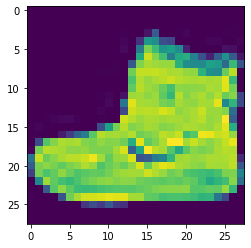

In [ ]:
i = 0
print(f"Sample {i} is a {y_train[i]}")
plt.imshow(x_train[i])

image = wandb.Image(x_train[i], caption=f"Training sample {i} is a {y_train[i]}")
wandb.log({"Example training image": image})

In [ ]:
# Log the datasets minimum and maximum intensities and datatype to the WandB summary
min_value = min(x_train.min(), x_test.min())
max_value = max(x_train.max(), x_test.max())
wandb_run.summary["raw"] = {"min": min_value, "max": max_value, "dtype": str(x_train.dtype)}

# Create a new histogram of the image pixels intensities
bin_names, train_hist = create_histogram(x_train)
log_bar(bin_names, train_hist, "Raw training data", x_name="bin", y_name="# pixels", keep_order=True)

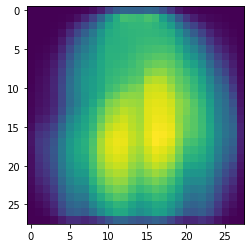

In [ ]:
# Create a heatmap over all active pixels from all frames
heatmap = np.mean(x_train, axis=0)
plt.imshow(heatmap)
wandb.log({"Heatmap of training images": wandb.Image(np.expand_dims(heatmap, axis=2), caption="The mean of all images in the training set")})

# Log a histogram of the average value for each pixel through out the
# training dataset. This shows us how many of the pixels that are
# always zero in all frames.
bin_names, heatmap_hist = create_histogram(heatmap.flatten(), bins=[0, 1, 10, 30, 100, 255])
log_bar(bin_names, heatmap_hist, "Average value per pixel in training data", x_name="bin", y_name="# pixels", keep_order=True)

## Preprocess the data
Now that we understand the data we are ready to preprocess the images to make them suitable for training of a deep learning model.

In [ ]:
# Normalize the values to the range -1...1
x_train_norm = x_train / 128 - 1
x_test_norm = x_test / 128 - 1


In [ ]:
x_train_norm *= np.random.random(size=x_train_norm.shape)

In [ ]:
# Create a new histogram of the modified values
min_value = min(x_train_norm.min(), x_test_norm.min())
max_value = max(x_train_norm.max(), x_test_norm.max())
wandb_run.summary["preprocessed"] = {"min": min_value, "max": max_value, "dtype": str(x_train_norm.dtype)}

bin_names, train_hist = create_histogram(x_train_norm)
log_bar(bin_names, train_hist, "Preprocessed training data", x_name="bin", y_name="# pixels", keep_order=True)

Sample 0 is number 9


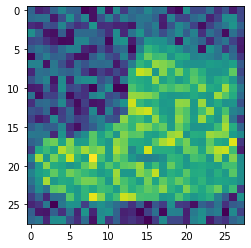

In [ ]:
i = 0
print(f"Sample {i} is number {y_train[i]}")
plt.imshow(x_train_norm[i])

image = wandb.Image(x_train_norm[i], caption=f"Training sample {i} is a {y_train[i]}")
wandb.log({"Example training image (preprocessed)": image})

## Subsample the test data set
If the test data set has different number of samples from different labels we will need to weight the different classes differently when evaluating our model if we want each number to be treated as equally importatant. Another option is to subsample so that the test data set has the same number of each label and ignoring the other images.

In [ ]:
num_images_per_label = Counter(y_test)
min_number_of_labels = min(num_images_per_label.values())

indexes_to_keep = []
for label in num_images_per_label.keys():
  indexes_to_keep.extend(
      np.random.choice(
          np.where(y_test == label)[0],
          size=min_number_of_labels,
          replace=False
      ).tolist()
  )

np.random.shuffle(indexes_to_keep)
x_test_norm_subsamp = x_test_norm[indexes_to_keep]
y_test_subsamp = y_test[indexes_to_keep]

In [ ]:
x_test_norm_subsamp.shape

(10000, 28, 28)

This should be a 0


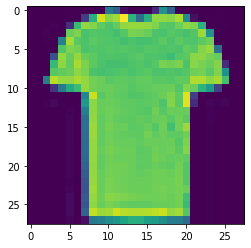

In [ ]:
# Verify that the labels and images are still in sync
print(f"This should be a {y_test_subsamp[0]}")
plt.imshow(x_test_norm_subsamp[0])

In [ ]:
# Log the new distribution
num_images_per_label = Counter(y_test_subsamp)
labels_, num_images = zip(*((str(label), number) for label, number in sorted(num_images_per_label.items())))
log_bar(labels_, num_images, "Labels in test data (subsampled)", x_name="Label", y_name="# images")

*my codes

In [11]:
import sys
!{sys.executable} -m pip install numpy tensorflow
from IPython.display import clear_output
clear_output()
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [12]:


def create_cnn(input_shape, output_classes):
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(output_classes, activation="softmax"),
        ]
    )


In [13]:
def get_fashion_mnist_data():
    # Load the data and split it between train and test sets
    (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # Make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    # convert class vectors to binary class matrices
    num_classes = 10
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_test, y_test)

In [14]:
batch_size = 128
epochs = 2
# Get the training data
x_train, y_train = get_fashion_mnist_data()[0]


In [15]:
# Create a Convolutional Neural Network that
# expects a 28x28 pixel image with 1 color chanel (gray) as input
model = create_cnn((28, 28, 1), 10)

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, validation_split=0.1)


Epoch 1/2
422/422 [==============================] - 59s 136ms/step - loss: 0.6089 - accuracy: 0.7857 - val_loss: 0.4373 - val_accuracy: 0.8443
Epoch 2/2
422/422 [==============================] - 47s 112ms/step - loss: 0.3851 - accuracy: 0.8616 - val_loss: 0.3580 - val_accuracy: 0.8728


In [31]:
batch_size = 512
epochs = 12
from datetime import datetime

date_and_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

wandb.init(project="Övning3_v2",
           name=f"training {date_and_time}",
           config={"batch_size": batch_size, "epochs": epochs})
#from datetime import datetime

#date_and_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

#wandb_run = wandb.init(
#    project="Övning3_v2",
#    name=f"trainig {date_and_time}"
#)

In [32]:

model.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, validation_split=0.1,
          callbacks=[wandb.keras.WandbCallback()])
wandb.finish()


Epoch 1/12
422/422 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9551

wandb: Adding directory to artifact (/content/wandb/run-20221212_101316-15p24t3a/files/model-best)... Done. 0.0s


422/422 [==============================] - 47s 111ms/step - loss: 0.1266 - accuracy: 0.9551 - val_loss: 0.2796 - val_accuracy: 0.9088
Epoch 2/12
422/422 [==============================] - 46s 109ms/step - loss: 0.1218 - accuracy: 0.9555 - val_loss: 0.2922 - val_accuracy: 0.9085
Epoch 3/12
422/422 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9570

wandb: Adding directory to artifact (/content/wandb/run-20221212_101316-15p24t3a/files/model-best)... Done. 0.0s


422/422 [==============================] - 47s 111ms/step - loss: 0.1180 - accuracy: 0.9570 - val_loss: 0.2776 - val_accuracy: 0.9120
Epoch 4/12
422/422 [==============================] - 46s 110ms/step - loss: 0.1146 - accuracy: 0.9583 - val_loss: 0.2783 - val_accuracy: 0.9113
Epoch 5/12
422/422 [==============================] - 48s 113ms/step - loss: 0.1131 - accuracy: 0.9592 - val_loss: 0.2906 - val_accuracy: 0.9092
Epoch 6/12
422/422 [==============================] - 46s 108ms/step - loss: 0.1089 - accuracy: 0.9610 - val_loss: 0.3014 - val_accuracy: 0.9090
Epoch 7/12
422/422 [==============================] - 46s 109ms/step - loss: 0.1079 - accuracy: 0.9611 - val_loss: 0.2910 - val_accuracy: 0.9105
Epoch 8/12
422/422 [==============================] - 46s 109ms/step - loss: 0.1046 - accuracy: 0.9624 - val_loss: 0.2914 - val_accuracy: 0.9107
Epoch 9/12
422/422 [==============================] - 48s 113ms/step - loss: 0.1034 - accuracy: 0.9624 - val_loss: 0.3049 - val_accuracy: 0.9

accuracy,▁▁▂▃▄▅▅▆▆▇▇█
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▇▆▅▅▄▄▃▃▂▂▁
val_accuracy,▄▄█▇▄▄▆▆▁▂▅▃
val_loss,▁▃▁▁▃▅▃▃▅█▇▆
accuracy,0.96594
best_epoch,2
best_val_loss,0.27762
epoch,11
loss,0.09515
val_accuracy,0.90833
